In [1]:
#Подгружаем необходимые библиотеки для работы с данными и машинного обучения
import warnings
import timeit

import pandas as pd

import catboost
import phik
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  Lasso,
                                  ElasticNet)
from catboost import CatBoostRegressor
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             f1_score, 
                             roc_curve, 
                             roc_auc_score, 
                             confusion_matrix,
                             accuracy_score,
                             make_scorer)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose

#Подгружаем дополнительные полезные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Уберем warnings, чтобы не мешали
warnings.filterwarnings("ignore")

In [3]:
#Загружаем данные
data = pd.read_excel('C:/Users/kiril/OneDrive/Рабочий стол/Данила/bact_table.xlsx', sheet_name = 'final table')

In [4]:
data

,Участок,Oil rate increase,V_injection,Pososity,Permeability,Salinity,Temperature,Viscosity
0,San andreas,10,1.590000,7.9,1.70,40.0,46.0,4.5
1,Tupungato-Refugio,29,23.850000,18.0,300.00,42.0,71.0,9.0
2,Huabei,40,23.850000,23.2,240.00,14.0,82.0,40.0
3,Xinjiyang,36,23.850000,20.0,70.00,8.0,43.0,40.0
4,Fuyu,66,25.000000,26.9,241.00,3.6,32.0,1850.0
5,Baolige,73,29.166667,29.0,597.00,4.5,50.0,359.0
6,Big Wells (Texas),22,15.900000,20.0,40.00,34.0,81.0,2.5
7,Vizcacheras (Argentina),20,0.318182,25.0,1000.00,65.0,92.2,6.3
8,Lobitos (Peru),21,0.318182,9.6,4.85,19.0,54.4,13.5
9,Providencia (Peru),17,0.318182,15.0,17.00,14.5,45.0,6.5


In [5]:
data.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
Oil rate increase,11.0,33.636,19.966,10.000,20.500,29.00,38.000,73.0
V_injection,11.0,16.378,13.353,0.318,0.954,23.85,24.425,36.0
Pososity,11.0,19.236,6.708,7.900,16.000,20.00,24.100,29.0
Permeability,11.0,230.595,313.786,1.700,21.000,70.00,270.500,1000.0
Salinity,11.0,22.645,19.972,3.600,6.250,14.50,37.000,65.0
Temperature,11.0,59.236,19.305,32.000,45.500,54.40,76.000,92.2
Viscosity,11.0,212.818,552.887,2.500,6.400,9.70,40.000,1850.0


In [6]:
#Не нужен для модели
data = data.drop(['Участок'], axis=1)

Также было замечено с помощью нескольких прогонов моделей и использования команд ниже, что некоторые признаки ухудшают качество модели. Поэтому в новом используемом датасете коллега уже учел данные нюансы и рекомендацию о более внимательной подготовке данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Oil rate increase  11 non-null     int64  
 1   V_injection        11 non-null     float64
 2   Pososity           11 non-null     float64
 3   Permeability       11 non-null     float64
 4   Salinity           11 non-null     float64
 5   Temperature        11 non-null     float64
 6   Viscosity          11 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 744.0 bytes


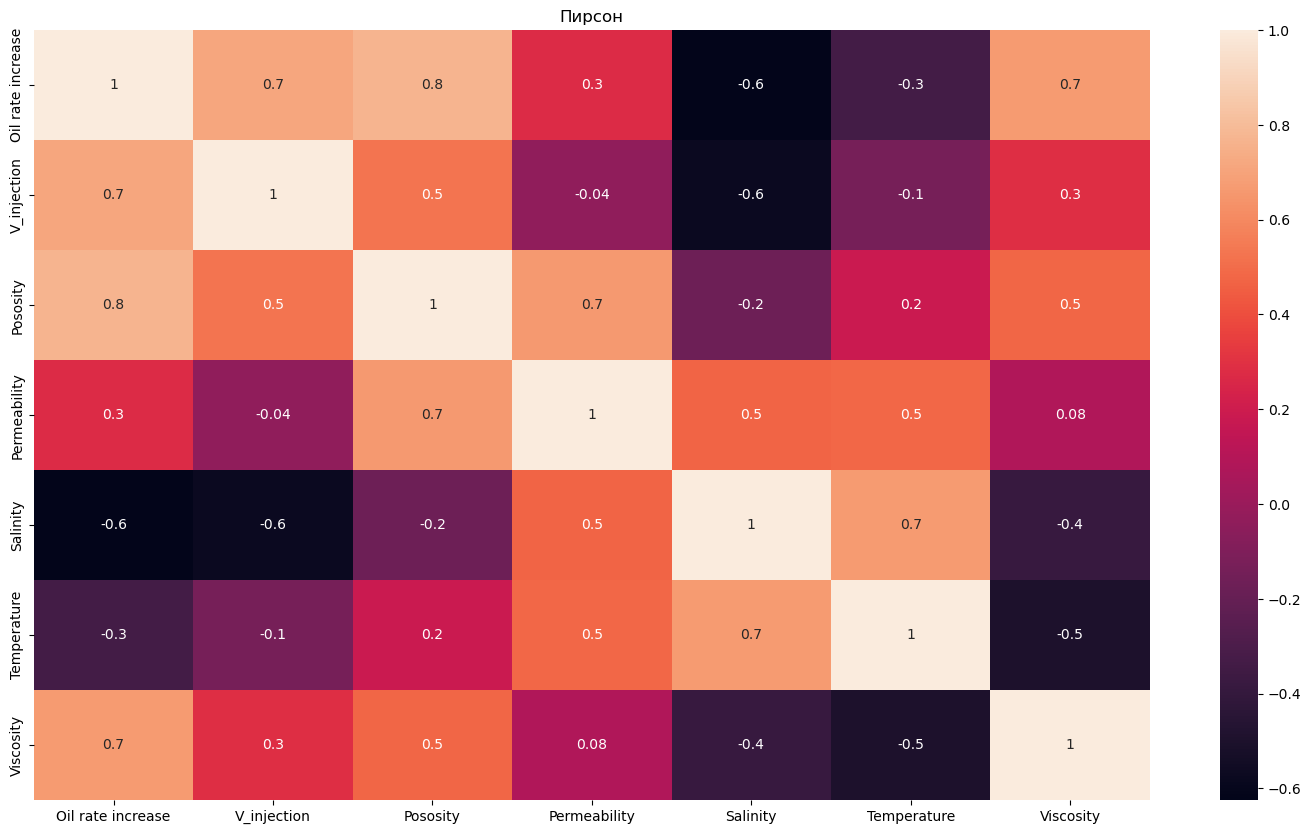

In [8]:
#Выведем тепловую карту, чтобы понять, какие параметры наибольшим образом коррелируют между собой
plt.figure(figsize=(18,10))
plt.title('Пирсон')
sns.heatmap(data.corr(method='pearson'), annot=True, fmt='.1g');

In [9]:
#Разделим данные на выборки 75:25
features = data.drop('Oil rate increase', axis=1)
target = data['Oil rate increase']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(8, 6)
(8,)
(3, 6)
(3,)


In [10]:
best_score_set = []

Из-за малого количества данных использование кросс-валидации ухудшает качество моделей

In [11]:
best_mae_test = 1000
for i in range(2, 7):
    DT = DecisionTreeRegressor(random_state=12345, max_depth=i)
    DT.fit(features_train, target_train)
    predictions = DT.predict(features_test)
    mae_test = mean_absolute_error(target_test, predictions)
    if mae_test < best_mae_test:
        best_mae_test = mae_test
        best_depth = i
        best_model_DT = DT

best_score_set.append(round(best_mae_test, 3))        

print(20 * '-')
print('Для DT:')
print('Лучшая модель:', best_model_DT)
print(f'Лучшие гиперпараметры: глубина = {best_depth}')
print('Лучший MAE:', round(best_mae_test, 3))

--------------------
Для DT:
Лучшая модель: DecisionTreeRegressor(max_depth=3, random_state=12345)
Лучшие гиперпараметры: глубина = 3
Лучший MAE: 3.5


In [12]:
best_mae_test = 1000
for i in range(2, 7):
    for j in range(1, 100, 2):
        RF = RandomForestRegressor(verbose=0, n_jobs=-1, random_state=12345, max_depth=i, n_estimators=j)
        RF.fit(features_train, target_train)
        predictions = RF.predict(features_test)
        mae_test = mean_absolute_error(target_test, predictions)
        if mae_test < best_mae_test:
            best_mae_test = mae_test
            best_depth = i
            best_est = j
            best_model_RF = RF

best_score_set.append(round(best_mae_test, 3))        

print(20 * '-')
print('Для RF:')
print('Лучшая модель:', best_model_RF)
print(f'Лучшие гиперпараметры: глубина = {best_depth}, est = {best_est}')
print('Лучший MAE:', round(best_mae_test, 3))

--------------------
Для RF:
Лучшая модель: RandomForestRegressor(max_depth=2, n_estimators=1, n_jobs=-1,
                      random_state=12345)
Лучшие гиперпараметры: глубина = 2, est = 1
Лучший MAE: 4.889


In [13]:
LR = LinearRegression()
LR.fit(features_train, target_train)
predictions = LR.predict(features_test)
best_mae_test = mean_absolute_error(target_test, predictions)
best_model_LR = LR
best_score_set.append(round(best_mae_test, 3))        

print(20 * '-')
print('Для LR:')
print('Лучший MAE:', round(best_mae_test, 3))

--------------------
Для LR:
Лучший MAE: 14.286


In [14]:
best_mae_test = 1000
for i in range(2, 7):
    for j in range(1, 100, 2):
        LGBM = lgb.LGBMRegressor(verbose=-1, n_jobs=-1, random_state=12345, max_depth=i, n_estimators=j)
        LGBM.fit(features_train, target_train)
        predictions = LGBM.predict(features_test)
        mae_test = mean_absolute_error(target_test, predictions)
        if mae_test < best_mae_test:
            best_mae_test = mae_test
            best_depth = i
            best_est = j
            best_model_LightGBM = LGBM

best_score_set.append(round(best_mae_test, 3))        

print(20 * '-')
print('Для LGBM:')
print('Лучшая модель:', best_model_LightGBM)
print(f'Лучшие гиперпараметры: глубина = {best_depth}, est = {best_est}')
print('Лучший MAE:', round(best_mae_test, 3))

--------------------
Для LGBM:
Лучшая модель: LGBMRegressor(max_depth=2, n_estimators=1, random_state=12345, verbose=-1)
Лучшие гиперпараметры: глубина = 2, est = 1
Лучший MAE: 16.0


In [15]:
best_mae_test = 1000
for i in range(2, 7):
    for j in range(1, 100, 2):
        catboost = CatBoostRegressor(verbose=0, random_state=12345, max_depth=i, n_estimators=j)
        catboost.fit(features_train, target_train)
        predictions = catboost.predict(features_test)
        mae_test = mean_absolute_error(target_test, predictions)
        if mae_test < best_mae_test:
            best_mae_test = mae_test
            best_depth = i
            best_est = j
            best_model_catboost = catboost

best_score_set.append(round(best_mae_test, 3))        

print(20 * '-')
print('Для catboost:')
print('Лучшая модель:', best_model_catboost)
print(f'Лучшие гиперпараметры: глубина = {best_depth}, est = {best_est}')
print('Лучший MAE:', round(best_mae_test, 3))

--------------------
Для catboost:
Лучшая модель: <catboost.core.CatBoostRegressor object at 0x00000258DDB34EE0>
Лучшие гиперпараметры: глубина = 3, est = 19
Лучший MAE: 5.646


In [16]:
#Найдем время обучения и предсказания без RandomizedSearchCV и кросс-валидации
#Также добавим МAE после кросс-валидации и RandomizedSearchCV
time_fit_set = []
time_pred_set = []

for i in [best_model_DT,
          best_model_RF,
          best_model_LR,
          best_model_LightGBM,
          best_model_catboost]:
    
    model = i
    
    #Обучаем и фиксируем время обучения
    start_time_fit = timeit.default_timer()
    model.fit(features_train, target_train)
    time_fit = timeit.default_timer() - start_time_fit
    
    #Делаем прогноз и фиксируем время прогноза
    start_time_pred = timeit.default_timer()
    model.predict(features_test)
    time_pred = timeit.default_timer() - start_time_pred
    
    time_fit_set.append(round(time_fit, 3))
    time_pred_set.append(round(time_pred, 3))
    
pivot_model = pd.DataFrame({'MAE' : best_score_set, 
                            'Время обучения' : time_fit_set, 
                            'Время прогноза' : time_pred_set,
                           }, 
                            index=['Дерево решений', 'Случайный лес', 'Линейная регрессия', 'LGBM', 'Catboost'])

pivot_model

,MAE,Время обучения,Время прогноза
Дерево решений,3.500,0.004,0.002
Случайный лес,4.889,0.010,0.001
Линейная регрессия,14.286,0.001,0.001
LGBM,16.000,0.003,0.001
Catboost,5.646,0.048,0.003


In [17]:
#Найдем MAE на тестовой выборке
model = best_model_DT 
model.fit(features_train, target_train)
predictions = model.predict(features_test)
mae_test = mean_absolute_error(target_test, predictions)
print('-' * 20)
print('MAE тестовой выборки:', round(mae_test, 3))

--------------------
MAE тестовой выборки: 3.5


In [18]:
#Сравним результаты тестовой модели с константной
dummy_clf = DummyRegressor()
dummy_clf.fit(features_train, target_train)
predict_dummy = dummy_clf.predict(features_test)
mae_dummy = mean_absolute_error(target_test, predict_dummy)
print('MAE константной модели составляет:', mae_dummy.round(1))

MAE константной модели составляет: 16.0


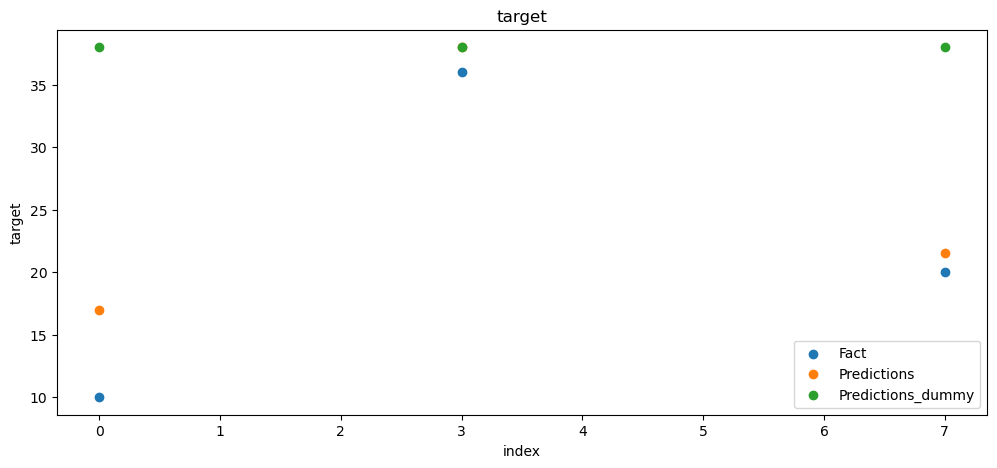

In [19]:
#Построим график для сравнения факта и прогноза
prediction = pd.DataFrame({'MAE' : predictions}, index=target_test.index)
plt.figure(figsize=(12,5))
plt.scatter(target_test.index, target_test, label='Fact')
plt.scatter(target_test.index, prediction, label='Predictions')
plt.scatter(target_test.index, predict_dummy, label='Predictions_dummy')
plt.title('target')
plt.xlabel('index');
plt.ylabel('target');
plt.legend();

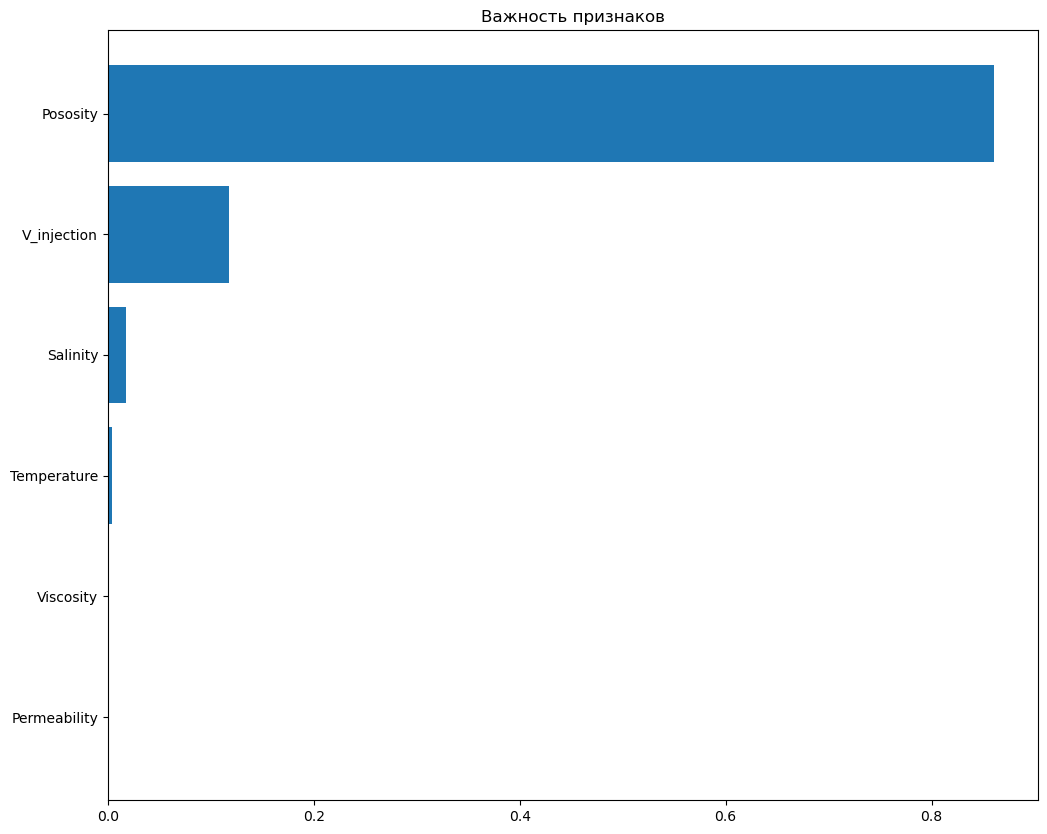

In [20]:
#Построим график важности признаков
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center');
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx]);
plt.title('Важность признаков');

In [22]:
#Проверяем интересующее нас месторождение
param_VU = pd.DataFrame ({'V_injection':[16.0], 
                         'Porosity':[11.0], 
                         'Permeability':[0.49], 
                         'Salinity':[235.0],
                         'Temperature':[35.0],
                         'Viscosity':[0.98]})
predict_VU = model.predict(param_VU)
print(f'Прирост дебита = {round(predict_VU[0], 1)}%')

Прирост дебита = 17.0%
